In [1]:
import sys
sys.path.append('..\\..')
import gdspy
import numpy as np
from importlib import reload
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator
from QCreator import meshing
reload(gdspy)

import matplotlib.pyplot as plt

In [2]:
jc = 0.5e-6  # 1e-6 # uA/um^2
layers_configuration = {
    'total': 0,
    'restricted area': 10,
    'for removing': 100,
    'JJs': 1,
    'air bridges': 2,
    'air bridge pads': 3,
    'air bridge sm pads': 4,
    'vertical gridlines': 0,
    'horizontal gridlines': 0,
    'inverted': 101,
    'bandages': 20
}

sample = creator.Sample('simple_fluxonium', layers_configuration)

# specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size = 4.7e3
sample.chip_geometry.sample_horizontal_size = 4.7e3
chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads, 350)
sample.add(chip_edge_ground)

In [3]:
# qubit params
flux_w = 10
flux_s = 6
flux_g = 20

In [4]:
fluxonium_squid =  {'jjs_height': 0.1,
                             'jjs_width': 0.115,
                             'jj_lead_width':0.5,
                             'chain_width':1.0,
                             'ics': 0.1*0.115*jc,
                             'icb': 0.5*1.0*jc,
                             'chain_junctions': 45,
                             'lm': 3.3e-12,
                             'squid_orientation': 'horizontal',
                             'jjs_distance': 0.16,
                             'chain_jj_distance': 0.1,
                             'chain_top_offset': 1.0,
                             'flux_line_outer_extension': 11}

In [5]:
from QCreator.elements.gflux_squid import GFluxControllableSquid

sl_position = (2350, 2350)

fluxonium_w = 20
fluxonium_s = 15
fluxonium_g = 30

squid = GFluxControllableSquid(name='fluxonium-squid', 
                               position=sl_position, 
                               w=fluxonium_w, s=fluxonium_s, g=fluxonium_g,
                               layer_configuration=sample.layer_configuration, 
                               squid_params=fluxonium_squid,
                               flux_w=flux_w, flux_s=flux_s, flux_g=flux_g)

sample.add(squid)

{'jjs_height': 0.1, 'jjs_width': 0.115, 'jj_lead_width': 0.5, 'chain_width': 1.0, 'ics': 5.75e-09, 'icb': 2.5e-07, 'chain_junctions': 45, 'lm': 3.3e-12, 'squid_orientation': 'horizontal', 'jjs_distance': 0.16, 'chain_jj_distance': 0.1, 'chain_top_offset': 1.0, 'flux_line_outer_extension': 11}


In [6]:
fluxonium_cap_length = 400
open_ends = []
capacitors = []
for open_end_id, port_name in enumerate(['port1', 'port2']):
    position = -np.exp(1j*squid.get_terminals()[port_name].orientation)*fluxonium_cap_length
    position = np.asarray([np.real(position), np.imag(position)])
    position += squid.get_terminals()[port_name].position
    
    open_end = elements.OpenEnd(name='fluxonium-open-end'+str(open_end_id),
                                position=position,
                                 w=[squid.get_terminals()[port_name].w],
                                 s=[squid.get_terminals()[port_name].s, squid.get_terminals()[port_name].s],
                                 g=squid.get_terminals()[port_name].g,
                                 orientation=squid.get_terminals()[port_name].orientation+np.pi,
                                 layer_configuration=sample.layer_configuration,
                                 h1=20,
                                 h2=10)
    open_ends.append(open_end)
    sample.add(open_end)
    capacitor = sample.connect_cpw(open_end, squid, 'wide', port_name, points=[], 
                                   name='fluxonium-cap'+str(open_end_id))

# Add DC line

In [7]:
pad_geometry = {'pad_w': 250, 'pad_s': 146, 'pad_g': 8, 'pad_length': 250, 'narrowing_length': 100, 'stub_length': 100,
                'z0': 50}
pad = elements.Pad('pad',
                   (2350, 600),
                   -np.pi/2,
                   flux_w,
                   flux_s, flux_g,
                   layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry,
                   **pad_geometry)
sample.add(pad)
sample.connect_cpw(pad, squid, 'port', 'flux', name='flux-line', points=[])

[CPW "flux-line", l=1695.000]

In [23]:
sample.draw_design()
sample.watch()

# TLS simulation

In [10]:
tls, connections_flat, element_assignments = sample.get_tls()
omegas, gammas, modes = tls.get_modes()
omegas/(2*np.pi)

array([2.63968085e+09, 4.62027710e+09, 3.52904445e+10, 6.95610536e+10,
       8.85696048e+10, 8.90747435e+10, 9.75815628e+10, 1.01024231e+11,
       1.16399483e+11, 1.17534290e+11, 1.50245721e+11, 1.50341745e+11,
       3.01095656e+11, 3.01143596e+11, 4.05504263e+11, 4.05517367e+11,
       4.68027634e+11, 4.68027634e+11, 4.68028275e+11, 4.68028275e+11,
       4.74583096e+11, 4.74613537e+11, 5.11696558e+11, 5.11696558e+11,
       5.11717516e+11, 5.11717516e+11])

In [22]:
omegas/(2*gammas)

array([ 3.28979850e+07,  5.80499398e+07,  6.66106712e-01,  1.27691052e+00,
        4.69101815e-01,  8.47457021e-01,  6.75566136e+00,  5.24978112e+00,
       -9.67252273e-01, -9.53782119e-01,  9.65334943e+08,  9.66711268e+08,
        1.95573814e+09,  1.95383543e+09,  7.09982965e+09,  7.20461039e+09,
        9.84092730e-01, -9.84092730e-01,  9.84028690e-01, -9.84028690e-01,
        3.09722950e+09,  3.08271630e+09, -8.49970034e-01,  8.49970034e-01,
       -8.50039702e-01,  8.50039702e-01])

In [13]:
kerr_matrix = tls.get_perturbation([0, 1])
kerr_matrix

array([[-3.49989879e+06, -3.98236900e+06],
       [-3.98236900e+06, -4.23274961e+08]])

## Zero flux 

$
\hat{H} = 4 E_c \hat{n}^2 + \frac{1}{2} E_L \hat{\phi}^2 + \sum\limits_{i=1}^3 E_{ji} \left(1-\cos\left(\alpha_i\phi_i\right)\right)$

In [14]:
modes_subsystems = tls.define_modes_parameters(
            omegas[:2]/(2 * np.pi), modes[:2], kerr_matrix,
            tls.get_phi_dc(modes[:2], tls.i_dc()), epsilon_cross=0.005)

modes_subsystems

{'0': {'subsystem_id': [0],
  'Ec': array([[6.2795444e-25]]),
  'El': array([[6.36007375e-28]]),
  'Ej': [1.8923593762338568e-24, 3.70244225784885e-21, 3.70244225784885e-21],
  'alpha': array([[1.09759905e-05],
         [9.06397276e-03],
         [9.06371177e-03]]),
  'dc_phase': array([[0.],
         [0.],
         [0.]])},
 '1': {'subsystem_id': [1],
  'Ec': array([[6.27634928e-25]]),
  'El': array([[5.83502789e-27]]),
  'Ej': [1.8923593762338568e-24, 3.70244225784885e-21, 3.70244225784885e-21],
  'alpha': array([[ 0.81426122],
         [-0.00904747],
         [ 0.00904672]]),
  'dc_phase': array([[0.],
         [0.],
         [0.]])}}

$$
\hat{H} = 4 \left\{ \hat{n}_1 \hat{n}_2 \right\}^T \mathbf{E}_{c} \left\{ \hat{n}_1 \hat{n}_2 \right\} + \frac{1}{2} \left\{ \hat{\phi}_1 \hat{\phi}_2 \right\} \mathbf{E}_{L} \left\{ \hat{\phi}_1 \hat{\phi}_2 \right\}^T + \sum\limits_{i=1}^3 E_{ji} \left(1-\cos\left(\alpha_{i2}\phi_{1} + \alpha_{i2}\phi_{2}\right)\right)$$

In [24]:
modes_subsystems = tls.define_modes_parameters(
            omegas[:2]/(2 * np.pi), modes[:2], kerr_matrix,
            tls.get_phi_dc(modes[:2], tls.i_dc()), epsilon_cross=0.001)

modes_subsystems

{'0': {'subsystem_id': [1, 0],
  'Ec': array([[6.27634928e-25, 0.00000000e+00],
         [0.00000000e+00, 6.27954440e-25]]),
  'El': array([[5.83502789e-27, 0.00000000e+00],
         [0.00000000e+00, 6.36007375e-28]]),
  'Ej': [1.8923593762338568e-24,
   3.70244225784885e-21,
   3.70244225784885e-21,
   1.8923593762338568e-24,
   3.70244225784885e-21,
   3.70244225784885e-21],
  'alpha': array([[ 8.14261223e-01,  1.09759905e-05],
         [-9.04746865e-03,  9.06397276e-03],
         [ 9.04672125e-03,  9.06371177e-03]]),
  'dc_phase': array([[-1.96477289, -1.96477289],
         [-0.03469167, -0.03469167],
         [-0.07834893, -0.07834893]])}}

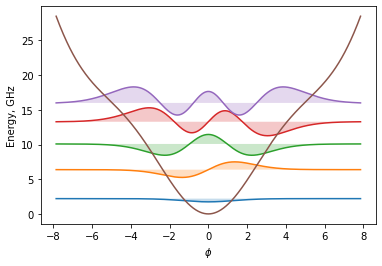

array([4.18016207e+09, 3.70472325e+09, 3.20065371e+09, 2.71640611e+09])

In [15]:
subsystem = modes_subsystems['1']
phi_grid = np.linspace(-np.pi*2.5, np.pi*2.5, 601)
dc_phase = modes_subsystems['1']['dc_phase']
tls.plot_wavefunctions_1d(subsystem, phi_grid, dc_phase, cutoff=5)
energies, wavefunctions = tls.solve_hamiltonian_eig_1d(subsystem, phi_grid, dc_phase, cutoff=5)
(energies[1:] - energies[:-1]) / (2 * np.pi * 1.054e-34)

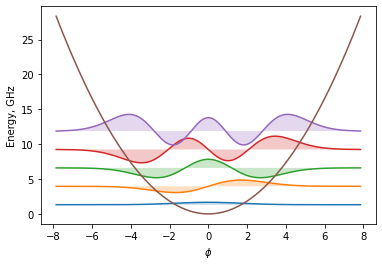

array([2.64072018e+09, 2.64033073e+09, 2.63997835e+09, 2.63991098e+09])

In [16]:
subsystem = modes_subsystems['0']
phi_grid = np.linspace(-np.pi*2.5, np.pi*2.5, 301)
dc_phase = modes_subsystems['0']['dc_phase']
tls.plot_wavefunctions_1d(subsystem, phi_grid, dc_phase, cutoff=5)
energies, wavefunctions = tls.solve_hamiltonian_eig_1d(subsystem, phi_grid, dc_phase, cutoff=5)
(energies[1:] - energies[:-1]) / (2 * np.pi * 1.054e-34)

## Half flux quantum

{'subsystem_id': [1], 'Ec': array([[6.27634928e-25]]), 'El': array([[5.83502789e-27]]), 'Ej': [1.8923593762338568e-24, 3.70244225784885e-21, 3.70244225784885e-21], 'alpha': array([[ 0.81426122],
       [-0.00904747],
       [ 0.00904672]]), 'dc_phase': array([[-0.02967001],
       [-0.00075057],
       [-0.00140983]])}


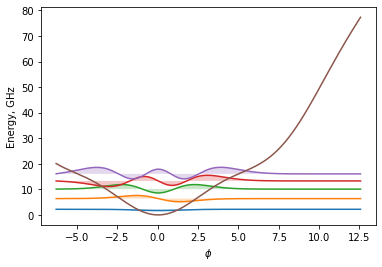

array([4.18010118e+09, 3.70505235e+09, 3.20683652e+09, 2.75774904e+09])

In [17]:
pad.tls_cache[-1].idc = 0.1e-4
modes_subsystems = tls.define_modes_parameters(
            omegas[:2]/(2 * np.pi), modes[:2], kerr_matrix,
            tls.get_phi_dc(modes[:2], tls.i_dc()), epsilon_cross=0.005)


subsystem = modes_subsystems['1']
print (subsystem)
phi_grid = np.linspace(-2*np.pi, np.pi*4, 601)
dc_phase = modes_subsystems['1']['dc_phase']
tls.plot_wavefunctions_1d(subsystem, phi_grid, dc_phase, cutoff=5)
energies, wavefunctions = tls.solve_hamiltonian_eig_1d(subsystem, phi_grid, dc_phase, cutoff=5)
(energies[1:] - energies[:-1]) / (2 * np.pi * 1.054e-34)

C:\Users\iliab\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


{'subsystem_id': [1], 'Ec': array([[6.27634928e-25]]), 'El': array([[5.83502789e-27]]), 'Ej': [1.8923593762338568e-24, 3.70244225784885e-21, 3.70244225784885e-21], 'alpha': array([[ 0.81426122],
       [-0.00904747],
       [ 0.00904672]]), 'dc_phase': array([[-1.96477289],
       [-0.03469167],
       [-0.07834893]])}
[[1.1601693780984839], [0.021089591029805937], [-0.021089589642413465]]


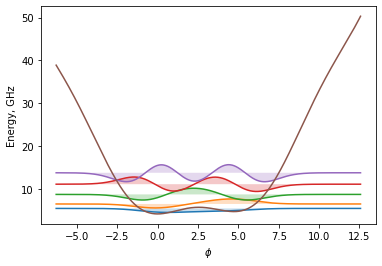

array([1.03915929e+09, 2.23178491e+09, 2.38667271e+09, 2.66396374e+09])

In [18]:
pad.tls_cache[-1].idc = 3.05e-4
subsystems = tls.get_scdc_subsystems()
tls.set_scdc_subsystem_phases(subsystems)

modes_subsystems = tls.define_modes_parameters(
            omegas[:2]/(2 * np.pi), modes[:2], kerr_matrix,
            tls.get_phi_dc(modes[:2], tls.i_dc()), epsilon_cross=0.005)


subsystem = modes_subsystems['1']
print (subsystem)
phi_grid = np.linspace(-2*np.pi, np.pi*4, 601)
dc_phase = [[tls.elements[1].stationary_phase/tls.elements[1].n_junctions], 
            [tls.elements[2].stationary_phase/tls.elements[2].n_junctions], 
            [tls.elements[3].stationary_phase/tls.elements[3].n_junctions]]
print (dc_phase)
tls.plot_wavefunctions_1d(subsystem, phi_grid, dc_phase, cutoff=5)
energies, wavefunctions = tls.solve_hamiltonian_eig_1d(subsystem, phi_grid, dc_phase, cutoff=5)
(energies[1:] - energies[:-1]) / (2 * np.pi * 1.054e-34)

In [67]:
2e-15/tls.elements[4].L

0.0006060606060606061